In [66]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path

# Hardcoded experiment directories (relative to current working dir)
experiment_dirs = [
    "vnet/data/TestVnetRunnerABR/VariableAvailableCapacityMultipleFlows",
    "vnet/data/TestVnetRunnerABR/VariableAvailableCapacitySingleFlow",
]

In [67]:
def load_experiments_from_dirs(experiment_dirs):
    experiments = {}

    for exp_dir in experiment_dirs:
        exp_path = Path(exp_dir)
        flows = {}

        for log_file in exp_path.glob("*.log"):
            parts = log_file.stem.split("_", 1)
            if len(parts) != 2:
                continue  # skip malformed names
            flow_id, log_type = parts
            flow_id = int(flow_id)

            if flow_id not in flows:
                flows[flow_id] = {}
            flows[flow_id][log_type] = log_file

        # Parse logs per flow
        experiments[exp_dir] = {}
        for flow_id, logs in flows.items():
            flow_data = {}

            if "cc" in logs:
                cc_log = pd.read_csv(logs["cc"], header=None, names=["time", "target_bitrate"])
                cc_log["time"] = pd.to_datetime(cc_log["time"], unit="ms")
                flow_data["cc_log"] = cc_log

            for side in ["sender", "receiver"]:
                for kind in ["rtp", "rtcp"]:
                    key = f"{side}_{kind}"
                    if key in logs:
                        if kind == "rtp":
                            df = pd.read_csv(logs[key], header=None, names=[
                                "time", "payload_type", "ssrc", "seq", "timestamp",
                                "marker", "size", "twcc", "unwrapped_seq"
                            ])
                            df["time"] = pd.to_datetime(df["time"], unit="ms")
                        else:
                            df = pd.read_csv(logs[key], header=None, names=["time", "size"])
                            df["time"] = pd.to_datetime(df["time"], unit="ms")
                        flow_data[key] = df

            experiments[exp_dir][flow_id] = flow_data

    return experiments


In [68]:
def compute_bitrates(experiments, window_ms=500):
    for exp_name, flows in experiments.items():
        for flow_id, data in flows.items():
            if "sender_rtp" in data:
                df = data["sender_rtp"]
                df["time_bin"] = df["time"].dt.floor(f"{window_ms}ms")
                bitrate_df = df.groupby("time_bin")["size"].sum().reset_index()
                bitrate_df["bitrate_kbps"] = (bitrate_df["size"] * 8) / (window_ms / 1000) / 1000
                data["bitrate"] = bitrate_df


In [69]:

def plot_experiment_bitrates(experiments):
    for exp_name, flows in experiments.items():
        plt.figure(figsize=(12, 6))
        plt.title(f"Bitrate Utilization - {exp_name}")
        plt.xlabel("Time")
        plt.ylabel("Bitrate (kbps)")

        n_flows = len(flows)
        colors = plt.colormaps.get_cmap('tab10').colors

        for i, (flow_id, data) in enumerate(flows.items()):
            color = colors[i % len(colors)]
            label = f"Flow {flow_id}"

            # RTP bitrate
            if "bitrate" in data:
                df = data["bitrate"]
                plt.plot(df["time_bin"], df["bitrate_kbps"], label=f"{label} RTP",
                         color=color, linestyle='-')

            # CC target
            if "cc_log" in data:
                cc = data["cc_log"]
                plt.plot(cc["time"], cc["target_bitrate"] / 1000, label=f"{label} Target",
                         color=color, linestyle='--')

        plt.legend()
        plt.tight_layout()
        plt.show()

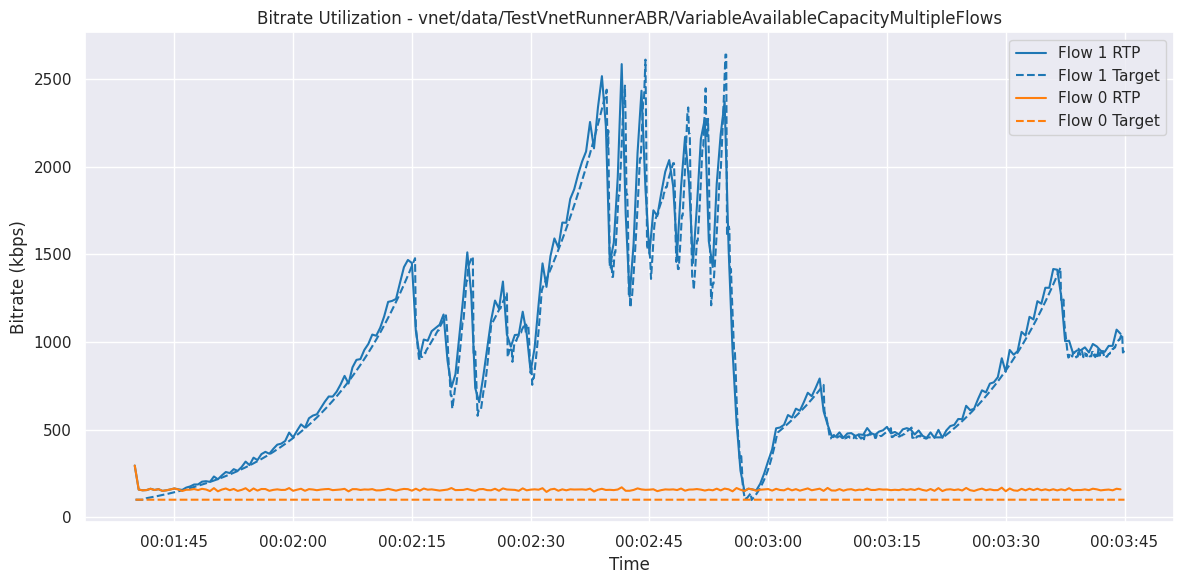

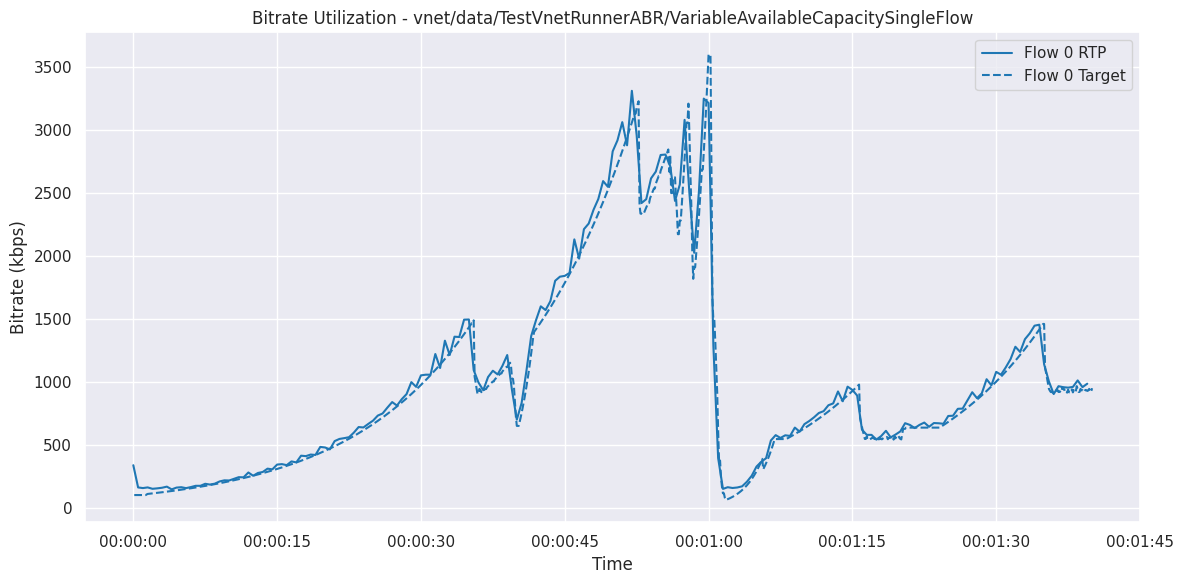

In [70]:
experiments = load_experiments_from_dirs(experiment_dirs)
compute_bitrates(experiments)
plot_experiment_bitrates(experiments)
